# Dynamic Functional Connectivity Analysis Using Hidden Semi-Markov  Models
*Written by Heather Shappell*

# Overview

The study of functional brain networks, where the brain is viewed as a system of interacting regions (nodes/vertices) that produce complex behaviors, has grown rapidly over the past decade. Brain networks can be created by performing a functional connectivity (FC) analysis, where the strength of the relationship between nodes is evaluated using the fMRI time series associated with each node. The nodes can consist of individual voxels, pre-specified regions of interest (ROIs), or sets of regions estimated using independent component analysis (ICA). The relationship between nodes is quantified using a variety of metrics, with the most common being Pearon or partial correlation coefficients. 

While most FC analyses estimate one static, average network for the entire length of the fMRI time series, there is increased interest in studying time-varying changes in FC. In other words, researchers are interested in investigating the patterns of state traversal in individuals and comparing these patterns across subject groups in both resting-state fMRI studies and task-based fMRI studies. 

In recent years, Hidden Markov models (HMMs) have proven to be a useful modeling approach towards assessing FC. In this context, it is assumed that the time series data at each brain region can be described via a series of a fixed number of hidden/unknown brain states. Each state is characterized by a multivariate Gaussian distribution, which is parameterized by the mean and covariance. Of particular interest is the unique connectivity structure of each state, encapsulated within the covariance matrix.

A limitation of the standard HMM approach is that the sojourn time, the number of consecutive time points spent in a specific state, is geometrically distributed. A property of the geometric distribution is that the probability decreases as the sojourn time increases. Therefore, more weight is placed on shorter consecutive time points in a given state. This may not be appropriate in the context of functional connectivity analysis, as it suggests subjects are switching states very often, as opposed to potentially spending longer periods of time in the same state. It also suggests that the sojourn time for all states follow a very similar pattern, which may not be the case in practice.

A possible solution to this issue, if it is of concern to the researcher, is to explicitly model and estimate the sojourn distribution via Hidden semi-Markov models (HSMMs). HSMMs differ from the standard HMM in that the sojourn distribution is explicitly built into the likelihood function. One may specify the distribution to take a nonparametric form or a parametric form (such as a Poisson or Gamma distribution) and estimate the parameters directly.

In this tutorial, we will demonstrate how to fit the HSMM in R and view the resulting output on the Sherlock video data set. For more information on using HSMMs for dynamic connectivity analysis, please refer to: 



# Data Preparation

Prior to running the HSMM analysis, your data should be pre-processed and organized into subject files where the data is organized as a T x P matrix, where T is the length of the time series and P is the number of ROIs you wish to include in the connectivity analysis. All subject files should contain the same number of ROIs, but the time series lengths may differ by subject.

This tutorial will utilize the Sherlock data subject files, where each participant has two files - part 1 and part 2. There are 16 participants.

Let's read the files into R, but before we get started with reading in the data, we need to install and load the R packages we will need for this tutorial. 

In [1]:
#The following code will install the R packages we will need.
#install.packages("MASS")
#install.packages("distr")
#install.packages("mvtnorm")
#install.packages("mhsmm")
#install.packages("gplots")
#install.packages("rasterVis")
#install.packages("lattice")
#install.packages("shapes")

#The following code will load the R packages we will need.
library(MASS)
library(mvnmle)
library(distr)
library(mvtnorm)
library(mhsmm)
library(gplots)
library(rasterVis)
library(lattice) 
library(shapes)

Loading required package: startupmsg
Utilities for Start-Up Messages (version 0.9.6)
For more information see ?"startupmsg", NEWS("startupmsg")

Loading required package: sfsmisc
Object Oriented Implementation of Distributions (version 2.8.0)
Attention: Arithmetics on distribution objects are understood as operations on corresponding random variables (r.v.s); see distrARITH().
Some functions from package 'stats' are intentionally masked ---see distrMASK().
Note that global options are controlled by distroptions() ---c.f. ?"distroptions".
For more information see ?"distr", NEWS("distr"), as well as
  http://distr.r-forge.r-project.org/
Package "distrDoc" provides a vignette to this package as well as to several extension packages; try vignette("distr").


Attaching package: 'distr'

The following objects are masked from 'package:stats':

    df, qqplot, sd

Warning message:
"package 'gplots' was built under R version 3.6.3"
Attaching package: 'gplots'

The following object is masked fro

Next, we will read the data into R. The Sherlock subject files should be saved to their own folder, with no other files in the folder. Specify the current directory of the folder, and read in the data as follows. This code will concatenate the subject data into one data frame, where the data from subject one (part 1 and 2) will appear first, followed by subject two (part 1 and 2), etc...

In [2]:
#Set the working directory.
setwd("C:\\Users\\heath\\Downloads\\AverageROI\\AverageROI")

#Get names of subject files in the folder.
filenames<- list.files(path=getwd())  

#View the subject file names to ensure they have read in correctly.
filenames

[1] "sub-01_Part1_Average_ROI_n50.csv" "sub-01_Part2_Average_ROI_n50.csv"
 [3] "sub-02_Part1_Average_ROI_n50.csv" "sub-02_Part2_Average_ROI_n50.csv"
 [5] "sub-03_Part1_Average_ROI_n50.csv" "sub-03_Part2_Average_ROI_n50.csv"
 [7] "sub-04_Part1_Average_ROI_n50.csv" "sub-04_Part2_Average_ROI_n50.csv"
 [9] "sub-05_Part1_Average_ROI_n50.csv" "sub-05_Part2_Average_ROI_n50.csv"
[11] "sub-06_Part1_Average_ROI_n50.csv" "sub-06_Part2_Average_ROI_n50.csv"
[13] "sub-07_Part1_Average_ROI_n50.csv" "sub-07_Part2_Average_ROI_n50.csv"
[15] "sub-08_Part1_Average_ROI_n50.csv" "sub-08_Part2_Average_ROI_n50.csv"
[17] "sub-09_Part1_Average_ROI_n50.csv" "sub-09_Part2_Average_ROI_n50.csv"
[19] "sub-10_Part1_Average_ROI_n50.csv" "sub-10_Part2_Average_ROI_n50.csv"
[21] "sub-11_Part1_Average_ROI_n50.csv" "sub-11_Part2_Average_ROI_n50.csv"
[23] "sub-12_Part1_Average_ROI_n50.csv" "sub-12_Part2_Average_ROI_n50.csv"
[25] "sub-13_Part1_Average_ROI_n50.csv" "sub-13_Part2_Average_ROI_n50.csv"
[27] "sub-14_Part1_Average_ROI_n50.csv" "sub-14_Part2_Average_ROI_n50.csv"
[29] "sub-15_Part1_Average_ROI_n50.csv" "sub-15_Part2_Average_ROI_n50.csv"
[31] "sub-16_Part1_Average_ROI_n50.csv" "sub-16_Part2_Average_ROI_n50.csv"

In [3]:
#Loop through each file name to read it in, and center and scale data so that each column (ROI) has a mean of 0 and a 
#standard deviation of 1.

DataReadIn <- lapply(filenames,function(i){
  table<-read.csv(i, header = TRUE, row.names=NULL)
  table<-scale(table)
  return(table)
})

DataFinal<-do.call(rbind, DataReadIn)
DataFinal<-as.data.frame(DataFinal)

In [6]:
#Let's also grab the time series length for every file we have read in and save this informatiom. 

TimeSerLen <- lapply(filenames,function(i){
  table<-read.csv(i, header = TRUE, row.names=NULL)
  Nrows<-nrow(table)
  return(Nrows)
})

Lengths<-do.call(rbind, TimeSerLen)

# Model Parameter Initialization and Model Specification

Now, we need to initiliaze the HSMM model parameters. These parameters are

- One P x P covariance matrix and a  1 x P  mean vector for each state.
- A state transition probability matrix.
- An initial state probability matrix.
- Sojourn distribution parameters for each state (this will depend on which sojourn distribution you would like to fit).

The R package that we are using to fit the model is the MHSMM R package, created by Jared O’Connell, et al. For a more in debt review of this package, please see:

O’Connell, Jared, and Søren Højsgaard. "Hidden semi markov models for multiple observation sequences: The mhsmm package for R." Journal of Statistical Software 39.4 (2011): 1-22.

and

O'Connell, Jared, Søren Højsgaard, and Maintainer Jared O'Connell. "Package ‘mhsmm’." CRAN (2017): 16.

Before fitting the model, one needs to decide how many states to fit. The model can ultimately be fit several times, for several numbers of states. The number of states you choose to fit is largely driven by the number of subjects you have, the length of the time series, the number of ROIs you are working with, etc. For the purpose of this tutorial, we will fit the data to 4 states.

In [7]:
###########################################################################################################
#Initialize mean and covariance matrices for each state because the model needs a starting point.
##########################################################################################################

#To do this, we will divide most of the data into sections that equal the number of states the model is fitting 
#and then, we will find the mean and covariance for each state. Again, this is just a rough estimate for the estimation 
#routine to have a place to begin, so there are many options for how you choose to initialize your model parameters.

#Let's specify the number of states we wish to fit
number_states = 4

#Let's also create a variable for the number of scans (i.e. two for each subject) and the number of ROIs
number_runs<-nrow(Lengths)
number_regions<-ncol(DataFinal)

#First, let's divide the data into sections. 
output_array = list()
seglength<-ceiling(min(Lengths[,1])/number_states)

for(i in 1:number_states)
{
  output_array[[i]]<-matrix(NA,nrow=1,ncol=number_regions)
  colnames(output_array[[i]])<-colnames(DataFinal)
  for(j in 1:number_runs){
    output_array[[i]]<-rbind(output_array[[i]],DataFinal[(1+sum(Lengths[1:(j-1),1]) + seglength*(i-1)):(sum(Lengths[1:(j-1),1])+seglength*i),])
  }
  output_array[[i]]<-output_array[[i]][-1,]
}

#Now find mean and covariance for each section.

MeanEst <- lapply(output_array,function(i){
  means<-mlest(i)$muhat
  return(means)
})

CovEst <- lapply(output_array,function(i){
  covs<-mlest(i)$sigmahat
  return(covs)
})

Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"Warning message in mysort(data):
"NAs introduced by coercion to integer range"

In [8]:
#Now we will initialize the remaining model parameters.

#These are initial state probabilities for the algorithm. We will make them all uniform unless we have prior beliefs
#for what they may be.
initial <- rep(1/number_states, number_states)

#This initializes a state transition probability matrix. Again, we will make these uniform.
TransMatrix<-matrix(NA, nrow=number_states, ncol=number_states)
diag(TransMatrix)<-0
TransMatrix[is.na(TransMatrix)] <- (1/(number_states-1))

##This saves the initial mean and covariances to a list, which is what will be needed to fit the model.
b <- list(mu = MeanEst, sigma = CovEst)

##This puts the data into a list to fit the model.
Datanew<-list(x = DataFinal, N = Lengths[,1])
class(Datanew) <- "hmm.data"


Lastly, we need to specify a sojourn distribution family (Gamma, Poisson, non-parametric, etc.) that we would like to fit, along with some initial estimates for the distribution parameters. Please refer to the above MHSMM package references for a complete list of sojourn distributions one may fit. For this tutorial, we will fit a Poisson sojourn distribution.

In [12]:
#This initializes the sojourn distribution. This is an example for fitting a Gamma distribution to each state.
#We randomly sample a shape and size parameter for each state to initialize the distribution.
d <- list(shape = sample(1:5, size=number_states), scale = sample(10:50, size=number_states), type = "gamma")


Now it is time to define the model and run it! The running of the model may take 10-15 minutes, so please be patient. :-)

In [13]:
##Now we combine everything into a model specification for the HSMM R package.
model1 <- hsmmspec(init = initial, trans = TransMatrix, parms.emis = b, dens.emis = dmvnorm.hsmm, 
                   sojourn = d)

##Now we run the model. This will take a few minutes to run.
testrun<-hsmmfit(Datanew, model1, mstep=mstep.mvnorm, lock.transition=FALSE, maxit=1000, lock.d=FALSE)


[1] 3.967762e-141  6.343814e-09
[1] 1.869280e-168  4.144979e-08
[1] 8.813897e-191  8.109241e-07
[1] 1.269818e-200  4.659947e-06
[1] 8.350049e-202  9.890380e-06
[1] 1.256697e-201  1.712156e-05
[1] 1.060702e-201  2.701871e-05
[1] 1.175951e-202  3.918128e-05
[1] 3.704175e-204  5.338990e-05
[1] 3.335943e-206  7.049855e-05
[1] 1.436810e-208  9.124688e-05
[1] 4.813983e-210  1.145812e-04
[1] 9.277992e-211  1.390331e-04
[1] 2.346788e-211  1.646909e-04
[1] 1.529255e-211  1.894122e-04
[1] 1.530951e-211  2.150711e-04
[1] 8.428315e-212  2.454989e-04
[1] 4.040785e-212  2.806942e-04
[1] 1.483601e-212  3.207696e-04
[1] 4.180541e-213  3.649052e-04
[1] 1.044585e-213  4.159342e-04
[1] 1.469732e-214  4.678955e-04
[1] 1.989016e-215  5.151305e-04
[1] 4.060597e-216  5.566405e-04
[1] 1.239802e-216  5.932163e-04
[1] 4.966446e-217  6.282586e-04
[1] 1.740785e-217  6.644735e-04
[1] 4.261341e-218  7.024722e-04
[1] 7.158466e-219  7.451353e-04
[1] 1.084124e-219  7.921957e-04
[1] 1.819336e-220  8.430769e-04
[1] 3.40

# Model Results

Now let's take a look at the model results! All of the results are saved in the testrun object. Let's first take a look at the correlation structure (i.e. our connectivity matrix) for each state!

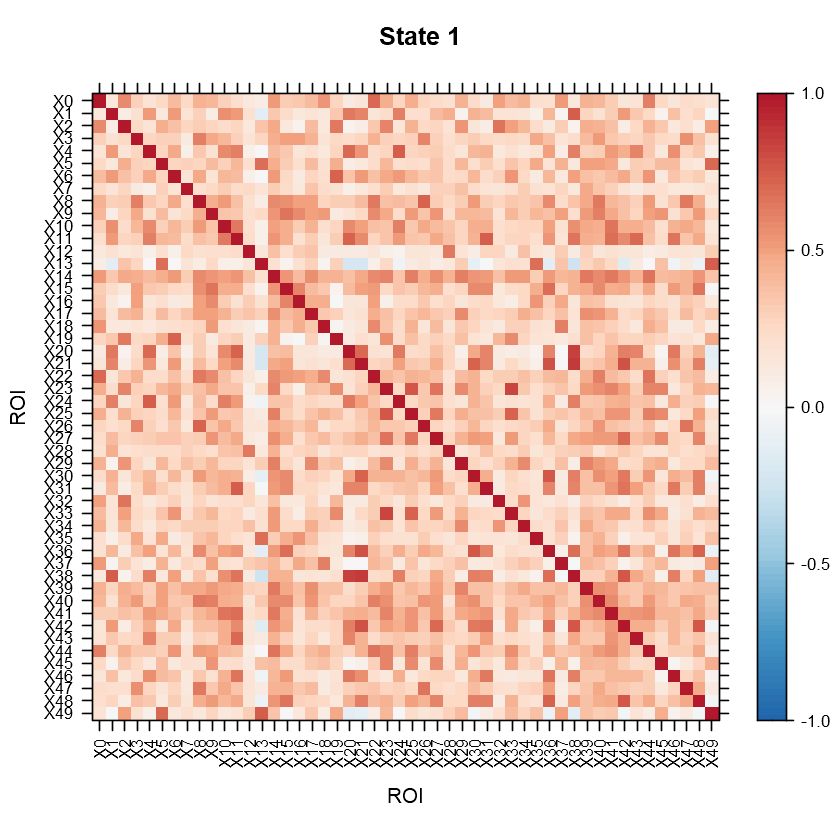

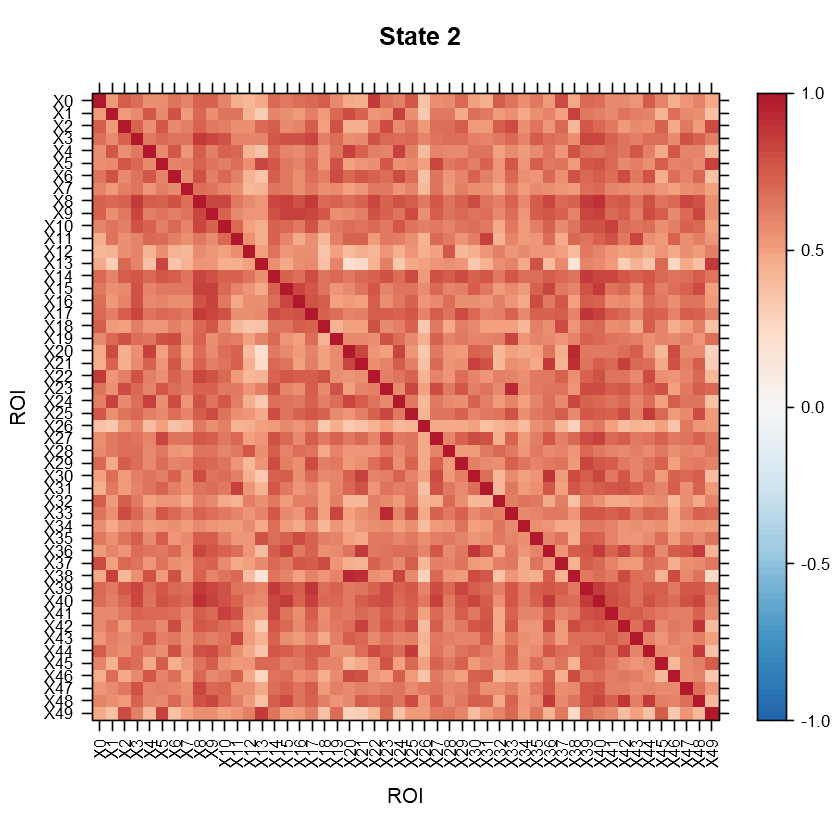

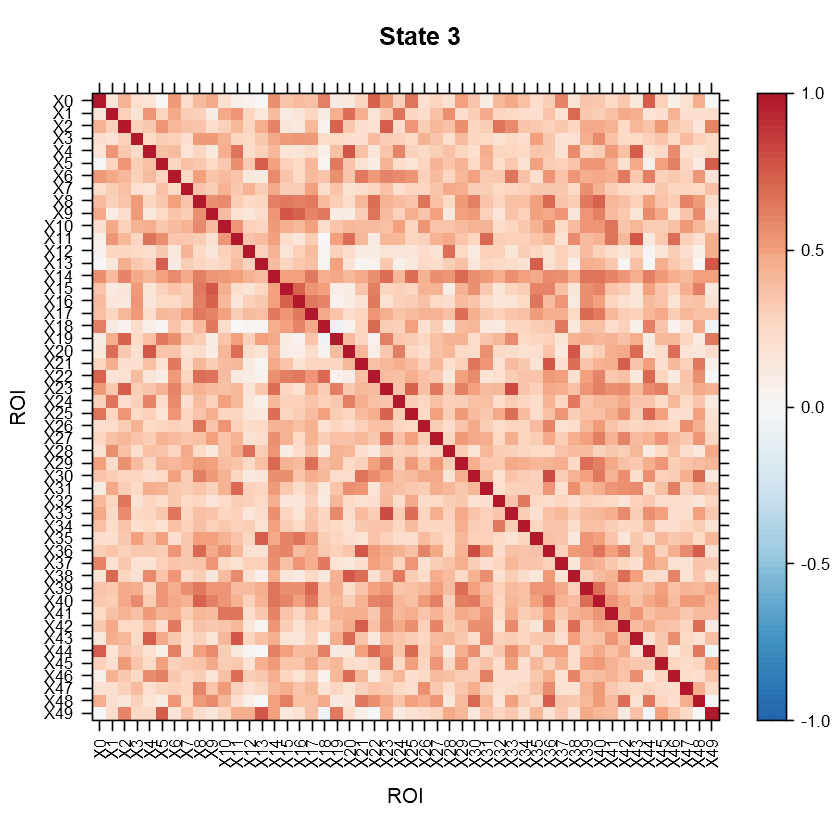

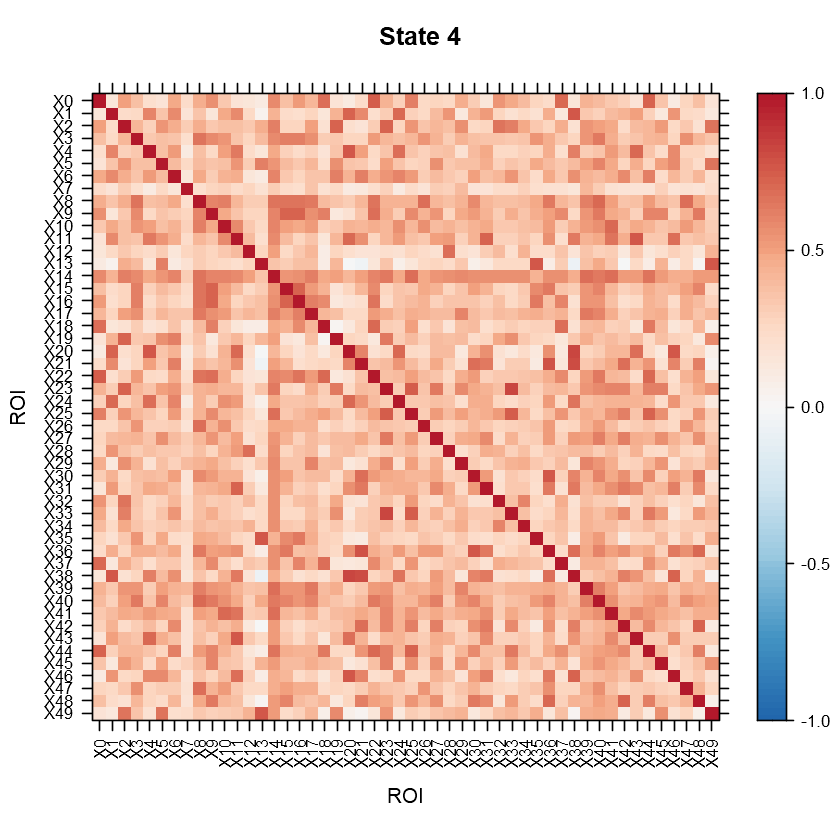

In [17]:
#Let's visualize the states correlation matrices.
cov1<-as.matrix(testrun$model$parms.emission$sigma[[1]])
cov2<-as.matrix(testrun$model$parms.emission$sigma[[2]])
cov3<-as.matrix(testrun$model$parms.emission$sigma[[3]])
cov4<-as.matrix(testrun$model$parms.emission$sigma[[4]])

#Convert the covariance matrices to correlation matrices.
Cor1<-cov2cor(cov1)
Cor2<-cov2cor(cov2)
Cor3<-cov2cor(cov3)
Cor4<-cov2cor(cov4)

#Set the color theme for the state plots we are about to make.
my.theme <- BuRdTheme()
my.at <- seq(-1,1,length.out=length(my.theme$regions$col)-1)
my.ckey <- list(at=my.at, col=my.theme$regions$col)

#After running this code, the states should display as images in R.
levelplot(as.matrix(Cor1[1:ncol(Cor1),ncol(Cor1):1]), par.settings=my.theme, at=my.at, colorkey=my.ckey, scales=list(x=list(rot=90)), main="State 1", xlab="ROI", ylab="ROI")
levelplot(as.matrix(Cor2[1:ncol(Cor2),ncol(Cor2):1]), par.settings=my.theme, at=my.at, colorkey=my.ckey, scales=list(x=list(rot=90)), main="State 2", xlab="ROI", ylab="ROI")
levelplot(as.matrix(Cor3[1:ncol(Cor3),ncol(Cor3):1]), par.settings=my.theme, at=my.at, colorkey=my.ckey, scales=list(x=list(rot=90)), main="State 3", xlab="ROI", ylab="ROI")
levelplot(as.matrix(Cor4[1:ncol(Cor4),ncol(Cor4):1]), par.settings=my.theme, at=my.at, colorkey=my.ckey, scales=list(x=list(rot=90)), main="State 4", xlab="ROI", ylab="ROI")



We can also look at the mean activation for each state by checking out the mean vectors for each state!

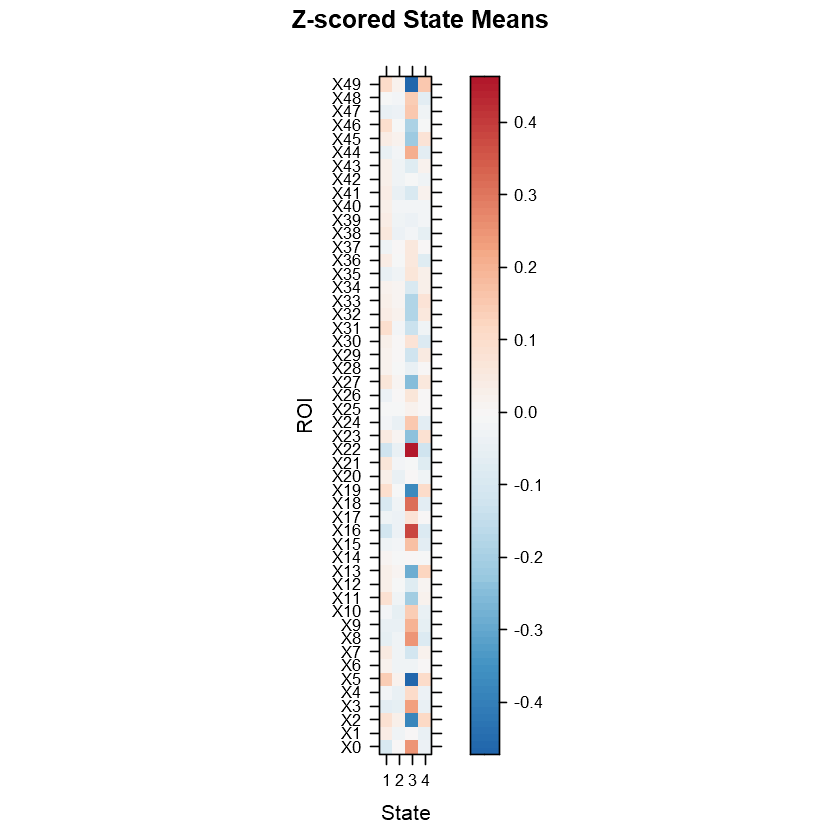

In [18]:
mean1<-as.matrix(testrun$model$parms.emission$mu[[1]])
mean2<-as.matrix(testrun$model$parms.emission$mu[[2]])
mean3<-as.matrix(testrun$model$parms.emission$mu[[3]])
mean4<-as.matrix(testrun$model$parms.emission$mu[[4]])

my.theme <- BuRdTheme()
my.at <- seq(min(as.matrix(t(cbind(mean1,mean2,mean3,mean4)))),max(as.matrix(t(cbind(mean1,mean2,mean3,mean4)))),length.out=length(my.theme$regions$col)-1)
my.ckey <- list(at=my.at, col=my.theme$regions$col)

#After running this code, we should see a plot showing the mean z-scored BOLD signals for each ROI (for each state).
levelplot(as.matrix(t(cbind(mean1,mean2,mean3,mean4))), par.settings=my.theme, at=my.at, colorkey=my.ckey,
          scales=list(y=list(at=1:number_regions, 
                             labels=row.names((mean1)))), ylab="ROI", las=0, xlab="State", main="Z-scored State Means")


Next, let's look at the state transition probability matrix. This will show us the probability of transitioning from one state to another state, given you are about to transition.

1,2,3,4
0.0000000,0.1598209,0.5689773,0.2712017
0.1178016,0.0000000,0.7177272,0.1644712
0.3905013,0.1772401,0.0000000,0.4322586
0.2389578,0.1327684,0.6282739,0.0000000


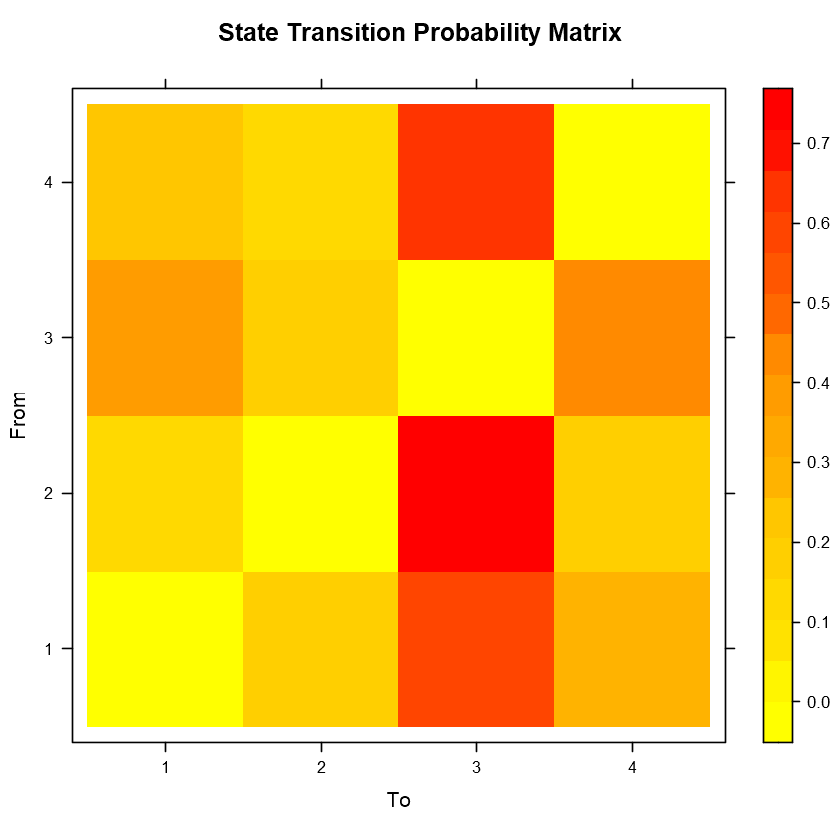

In [20]:
#Let's first look at the actual probabilities.
testrun$model$transition

#Now let's create a plot.
new.palette=colorRampPalette(c("yellow","orange","red"),space="rgb") 

rownames(testrun$model$transition)<-1:number_states
colnames(testrun$model$transition)<-1:number_states

levelplot(t(as.matrix(testrun$model$transition[1:ncol(testrun$model$transition),1:ncol(testrun$model$transition)])), col.regions=new.palette(20),
         xlab="To", ylab="From", main="State Transition Probability Matrix")


Now, let's take a look at the sojourn time distributions for each state. Remember that the sojourn time is the number of consecutive time points you spend in a state before switching to a different state.

$shape
[1] 0.6857703 0.2857704 1.5549228 0.5597562

$scale
[1] 29.173326 18.960612  3.904798 26.070095

$type
[1] "gamma"

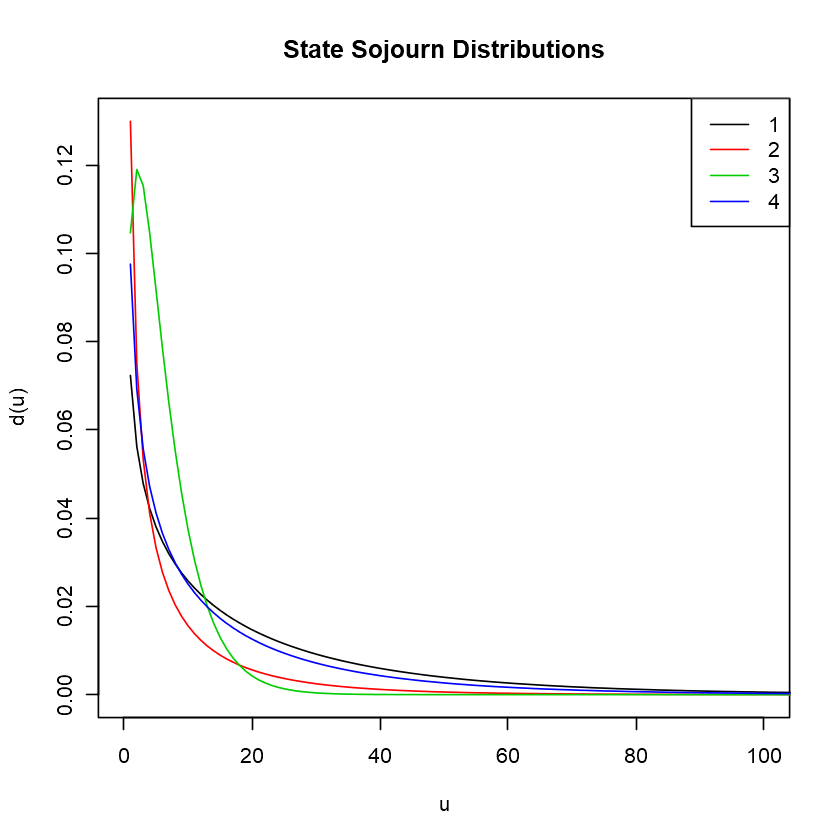

In [26]:
#Now let's plot the sojourn distribution for each state. The x-axis (i.e. 'u') is the sojourn time. The y-axis is the
#density.

plot(testrun, xlim=c(0,100), main="State Sojourn Distributions")

#To get actual sojourn distribution parameter estimations, you can run the following lien of code. It will give a vector
#estimated shape parameters and a vector of estimated scale parameters. The first number in each corresponds to the state 1
#estimate, the second the state 2 estimate, and so on...

testrun$model$sojourn

You may want to visualize the distance between the state correlation matrices in 2-D space. A multi-dimensional scaling plot will do this. It'll allow you to see how similar/disimilar your state correlation matrices are. If you are finding that some states appear to be overlapping, you may want to re-run your model and fit less states.

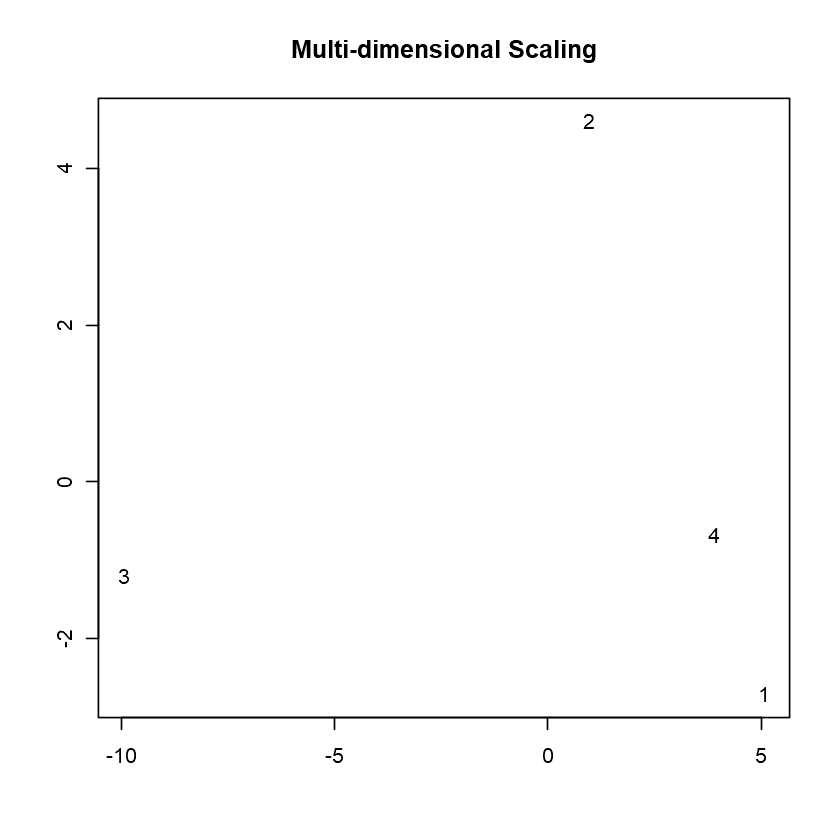

In [28]:
##Here is a way to calculate and visualize the Eucliden distance between each state in a 2D format.

dist<-matrix(NA, nrow=number_states, ncol=number_states)

for(i in 1:number_states)
{
  name1<-paste("cov", i, sep = "")
  for(j in 1:number_states)
  {
    name2<-paste("cov", j, sep = "")
    dist[i,j]<-distcov(as.matrix(get(name1)), as.matrix(get(name2)), method="Euclidean") 
  }
}

dist<-as.data.frame(dist)
rownames(dist)<-as.character(seq(1:number_states))
colnames(dist)<-as.character(seq(1:number_states))

mds <- cmdscale(dist)
plot(mds, type='n', main="Multi-dimensional Scaling", xlab=" ", ylab=" ")
text(mds[, 1], mds[, 2], labels(dist)[[1]])


As the above plot shows, states 1 and 2 are most disimilar, where as states 1 and 4 are most similar (with regards to connectivity structure). 

We can also look at the state sequence for each individual. The most likely state sequence, for each subject, is stored in the testrun object. Since this data consists of two parts for each subject, let's separate the results into part 1 vs. part 2.

In [39]:
#Let's create a data frame for the state sequence for all subjects for part 1.
number_timepoints_part1 <- 946

predfun<-function(i)
{
  subject <- rep(NA, number_timepoints_part1)
  time <- rep(NA, number_timepoints_part1)
  state <- rep(NA, number_timepoints_part1)
  Predict<-data.frame(subject, time, state)
  
  for(z in 1:number_timepoints_part1)
  {
    Predict$subject[z]=floor(i/2) + 1
    Predict$time[z]=z
    Predict$state[z]=testrun$yhat[z + sum(Lengths[(1:(i-1)),])]
  }
  
  return(Predict)
}

Together<-lapply(seq(1,nrow(Lengths),by=2), predfun)
Predict_part1<-do.call(rbind, Together)
Predict_part1

subject,time,state
<dbl>,<int>,<int>
1,1,3
1,2,3
1,3,3
1,4,3
1,5,3
1,6,3
1,7,1
1,8,1
1,9,3


Now let's do the same for part 2, for all subjects...

In [40]:
#Let's create a data frame for the state sequence for all subjects for part 2.
number_timepoints_part2 <- 1030

predfun2<-function(i)
{
  subject <- rep(NA, number_timepoints_part2)
  time <- rep(NA, number_timepoints_part2)
  state <- rep(NA, number_timepoints_part2)
  Predict<-data.frame(subject, time, state)
  
  for(z in 1:number_timepoints_part2)
  {
    Predict$subject[z]=i/2
    Predict$time[z]=z
    Predict$state[z]=testrun$yhat[z + sum(Lengths[(1:(i-1)),])]
  }
  
  return(Predict)
}

Together2<-lapply(seq(2,nrow(Lengths),by=2), predfun2)
Predict_part2<-do.call(rbind, Together2)
Predict_part2

subject,time,state
<dbl>,<int>,<int>
1,1,3
1,2,3
1,3,3
1,4,3
1,5,3
1,6,3
1,7,1
1,8,1
1,9,3


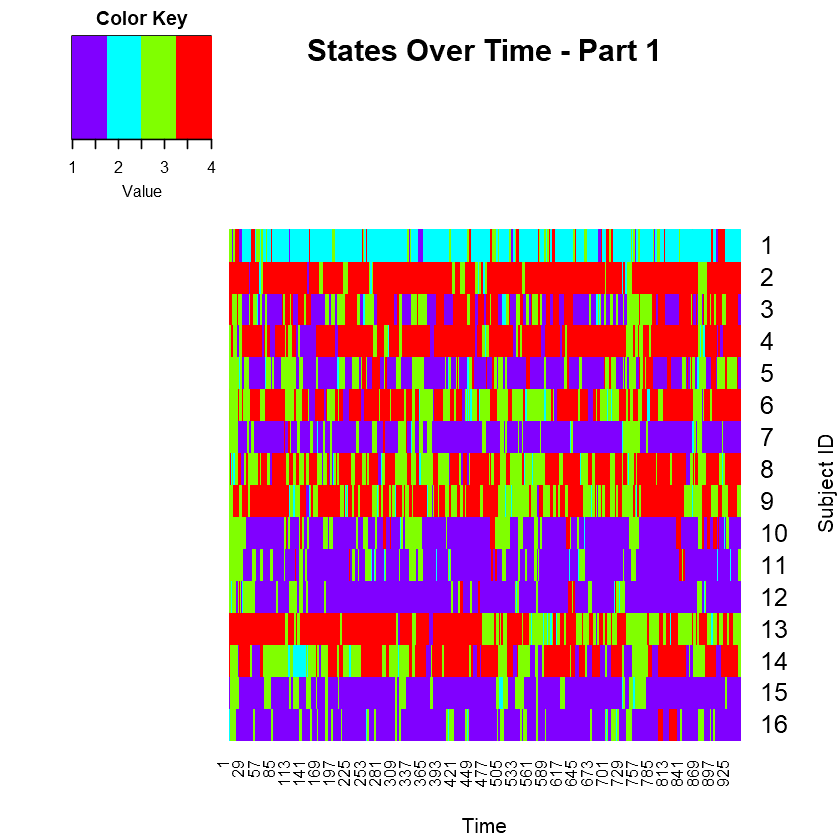

In [45]:
#Now you have the state information for each subject in a data frame. If you want, you can make
#visual summaries such as the one below.

forheat<-matrix(Predict_part1[,3], nrow=number_timepoints_part1, ncol=16, byrow=FALSE)
forheat2<-t(forheat)

heatmap.2(forheat2,  # same data set for cell labels
          main="States Over Time - Part 1",
          Rowv = c(1,16),
          notecol="black",      # change font color of cell labels to black
          density.info="none",  # turns off density plot inside color legend
          trace="none",     # widens margins around plot
          col=rev(rainbow(4)),    # enable color transition at specified limits
          dendrogram="none",     # only draw a row dendrogram
          ylab="Subject ID", xlab="Time",
          Colv="NA", key=TRUE, keysize = 1.5, cexRow=1.5, cexCol=1)





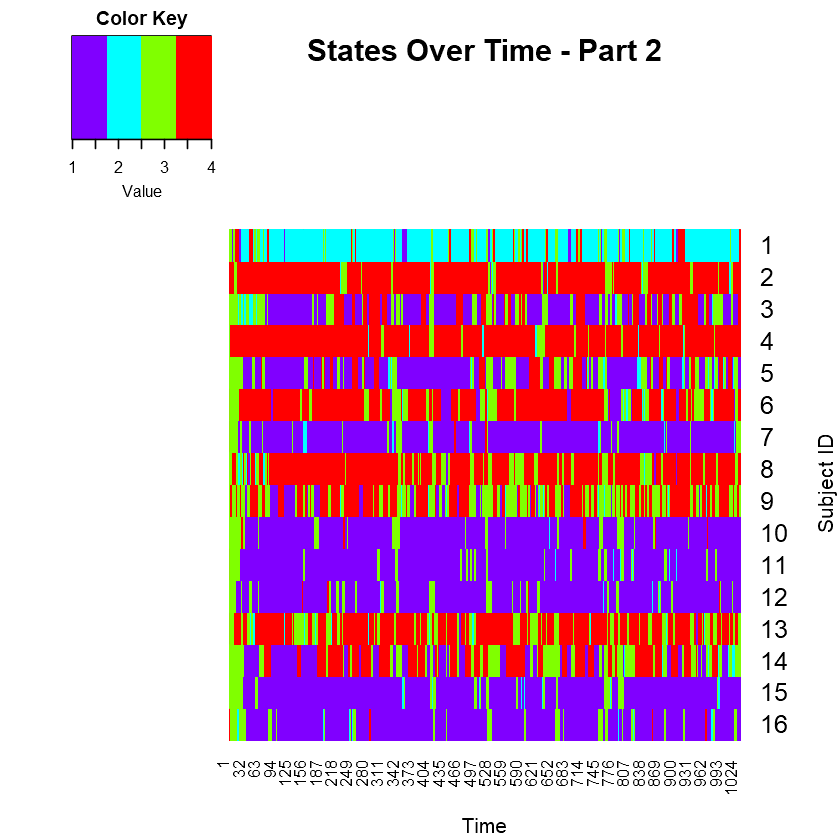

In [46]:
#Now you have the state information for each subject in a data frame. If you want, you can make
#visual summaries such as the one below.

forheat<-matrix(Predict_part2[,3], nrow=number_timepoints_part2, ncol=16, byrow=FALSE)
forheat2<-t(forheat)

heatmap.2(forheat2,  # same data set for cell labels
          main="States Over Time - Part 2",
          Rowv = c(1,16),
          notecol="black",      # change font color of cell labels to black
          density.info="none",  # turns off density plot inside color legend
          trace="none",     # widens margins around plot
          col=rev(rainbow(4)),    # enable color transition at specified limits
          dendrogram="none",     # only draw a row dendrogram
          ylab="Subject ID", xlab="Time",
          Colv="NA", key=TRUE, keysize = 1.5, cexRow=1.5, cexCol=1)


# Wrapping Up

The above code is just a sample of what you can do in R to fit the HSMMs to your data! We have presented the basics, but there is so much more to these analyses, such as conducting permutation tests to compare groups on sojourn times, state dwell times, transition probabilities, etc. We are also working on a covariate implementation of the HSMM, where the model allows for covariates to predict sojourn times! Stay tuned for some exciting developments in the near future!

# Recommended Reading

* Shappell H, Caffo BS, Pekar JJ, Lindquist MA. Improved state change estimation in dynamic functional connectivity using hidden semi-Markov models. Neuroimage. 2019;191:243‐257. doi:10.1016/j.neuroimage.2019.02.013.

# Contributions

Tutorial written by Heather Shappell. Edited by Luke Chang.